### 之前代码有问题，以最新版为准

# 任务

本次实践涉及到对Wav2Lip模型的，以及相关代码实现。总体上分为以下几个部分：
1. 环境的配置
2. 数据集准备及预处理
3. 模型的训练
4. 模型的推理

## Wav2Lip
**[Wav2Lip](https://arxiv.org/pdf/2008.10010.pdf)** 是一种基于对抗生成网络的由语音驱动的人脸说话视频生成模型。如下图所示，Wav2Lip的网络模型总体上分成三块：生成器、判别器和一个预训练好的Lip-Sync Expert组成。网络的输入有2个：任意的一段视频和一段语音，输出为一段唇音同步的视频。生成器是基于encoder-decoder的网络结构，分别利用2个encoder: speech encoder, identity encoder去对输入的语音和视频人脸进行编码，并将二者的编码结果进行拼接，送入到 face decoder 中进行解码得到输出的视频帧。判别器Visual Quality Discriminator对生成结果的质量进行规范，提高生成视频的清晰度。为了更好的保证生成结果的唇音同步性，Wav2Lip引入了一个预预训练的唇音同步判别模型 Pre-trained Lip-sync Expert，作为衡量生成结果的唇音同步性的额外损失。

### Lip-Sync Expert
Lip-sync Expert基于 **[SyncNet](https://www.robots.ox.ac.uk/~vgg/publications/2016/Chung16a/)**，是一种用来判别语音和视频是否同步的网络模型。如下图所示，SyncNet的输入也是两种：语音特征MFCC和嘴唇的视频帧，利用两个基于卷积神经网络的Encoder分别对输入的语音和视频帧进行降纬和特征提取，将二者的特征都映射到同一个纬度空间中去，最后利用contrastive loss对唇音同步性进行衡量，结果的值越大代表越不同步，结果值越小则代表越同步。在Wav2Lip模型中，进一步改进了SyncNet的网络结构：网络更深；加入了残差网络结构；输入的语音特征被替换成了mel-spectrogram特征。

## 1. 环境的配置
- `建议准备一台有显卡的linux系统电脑，或者可以选择使用第三方云服务器（Google Colab）` 
- `Python 3.6 或者更高版本` 
- ffmpeg: `sudo apt-get install ffmpeg`
- 必要的python包的安装，所需要的库名称都已经包含在`requirements.txt`文件中，可以使用 `pip install -r requirements.txt`一次性安装. 
- 在本实验中利用到了人脸检测的相关技术，需要下载人脸检测预训练模型：Face detection [pre-trained model](https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth) 并移动到 `face_detection/detection/sfd/s3fd.pth`文件夹下. 

In [1]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 28.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 56.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 kB 41.9 MB/s eta 0:00:00
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23706 sha256=81c55b6a5e9814e2e92a1b48843e19968ce5b1dab32082a558541ce56abb905f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/da/4b/39/c5f6c4ee93b43281dda4dab5ac5f2bdf9d11074d427493cd55
Successfully built audioread
 

## 2. 数据集的准备及预处理

**LRS2 数据集的下载**  
实验所需要的数据集下载地址为：<a href="http://www.robots.ox.ac.uk/~vgg/data/lip_reading/lrs2.html">LRS2 dataset</a>，下载该数据集需要获得BBC的许可，需要发送申请邮件以获取下载密钥，具体操作详见网页中的指示。下载完成后对数据集进行解压到本目录的`mvlrs_v1/`文件夹下，并将LRS2中的文件列表文件`train.txt, val.txt, test.txt` 移动到`filelists/`文件夹下，最终得到的数据集目录结构如下所示。
```
data_root (mvlrs_v1)
├── main, pretrain (我们只使用main文件夹下的数据)
|	├── 文件夹列表
|	│   ├── 5位以.mp4结尾的视频ID
```
**数据集预处理**
数据集中大多数视频都是包含人的半身或者全身的画面，而我们的模型只需要人脸这一小部分。所以在预处理阶段，我们要对每一个视频进行分帧操作，提取视频的每一帧，之后使用`face detection`工具包对人脸位置进行定位并裁减，只保留人脸的图片帧。同时，我们也需要将每一个视频中的语音分离出来。

In [2]:
# !wget "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" -O face_detection/detection/sfd/s3fd.pth

--2023-07-31 01:37:25--  https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth
Resolving www.adrianbulat.com (www.adrianbulat.com)... 45.136.29.207
Connecting to www.adrianbulat.com (www.adrianbulat.com)|45.136.29.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89843225 (86M) [application/octet-stream]
Saving to: ‘face_detection/detection/sfd/s3fd.pth’

100%[======================================>] 89,843,225  21.9MB/s   in 4.5s   

2023-07-31 01:37:31 (19.1 MB/s) - ‘face_detection/detection/sfd/s3fd.pth’ saved [89843225/89843225]



In [2]:
!rm -rf ../LSR2/demo
!mkdir -p ../LSR2/demo
!cp -r ../LSR2/main/553* ../LSR2/demo/

In [3]:
# !rm -rf ../LSR2/lrs2_preprocessed_288x288
# !python preprocess.py --data_root "../LSR2/main" --preprocessed_root "../LSR2/lrs2_preprocessed_288x288" --batch_size 128
!rm -rf ../LSR2/lrs2_preprocessed_288x288-demo
!python preprocess.py --data_root "../LSR2/demo" --preprocessed_root "../LSR2/lrs2_preprocessed_288x288-demo" --batch_size 128

^C
Started processing for ../LSR2/demo with 1 GPUs
100%|█████████████████████████████████████████| 432/432 [10:17<00:00,  1.43s/it]
Dumping audios...
100%|█████████████████████████████████████████| 432/432 [00:15<00:00, 28.79it/s]


预处理后的`lrs2_preprocessed/`文件夹下的目录结构如下
```
preprocessed_root (lrs2_preprocessed)
├── 文件夹列表
|	├── 五位的视频ID
|	│   ├── *.jpg
|	│   ├── audio.wav
```

In [2]:
import os
from tqdm import tqdm

codeformer_cmd = 'cd ../CodeFormer && python inference_codeformer.py --bg_upsampler realesrgan --face_upsample -w 1.0 --input_path {} --output_path {}'
preprocessed_root = "../LSR2/lrs2_preprocessed_288x288-demo"
sub_dirs = os.listdir(preprocessed_root)
for sub_dir in tqdm(sub_dirs):
    video_dirs = os.listdir(os.path.join(preprocessed_root, sub_dir))
    for video_dir in video_dirs:
        video_dir = os.path.join(preprocessed_root, sub_dir, video_dir)
        # print(video_dir)
        # print(codeformer_cmd.format(video_dir, video_dir))
        os.system(codeformer_cmd.format(video_dir, video_dir))

获取对应的文件列表并更新到filelists/train.txt和filelists/eval.txt。只保存对应的视频名称即可。代码可以参考，对视频样本重命名并生成对应的命名列表，此处视频文件数量过少<2，会报错：

In [8]:
import time
from glob import glob
import shutil,os
 
from sklearn.model_selection import train_test_split
 

# 去除名字的特殊符号，统一序号视频文件命名
 
# def original_video_name_format():
#     base_path = "../LSR2/main"
#     result = list(glob("{}/*".format(base_path),recursive=False))
#     file_num = 0
#     result_list = []
 
#     for each in result:
#         file_num +=1
#         new_position ="{0}{1}".format( int(time.time()),file_num)
#         result_list.append(new_position)
#         shutil.move(each, os.path.join(base_path,new_position+".mp4"))
#         pass

def trained_data_name_format():
    base_path = preprocessed_root
    # result = list(glob("{}/*".format(base_path)))
    result = os.listdir(base_path)
    print(result)
    result_list = []
    for i,dirpath in enumerate(result):
        # shutil.move(dirpath,"{0}/{1}".format(base_path,i))
        # result_list.append(str(i))
        # print('dirpath:', dirpath)
        result_list.append(dirpath)
    if len(result_list)<14:
        test_result=val_result=train_result=result_list
    else:
        train_result,test_result = train_test_split(result_list,test_size=0.15, random_state=42)
        test_result, val_result = train_test_split(test_result, test_size=0.5, random_state=42)
 
    for file_name,dataset in zip(("train.txt","test.txt","val.txt"),(train_result,test_result,val_result)):
        with open(os.path.join("filelists",file_name),'w',encoding='utf-8') as fi:
            for dataset_i in dataset:
                # print('dataset_i:', dataset_i)
                video_result = os.listdir(os.path.join(base_path, dataset_i))
                # print('video_result:', video_result)
                video_result = [dataset_i+'/'+video+'/final_results' for video in video_result]
                fi.write("\n".join(video_result))
                fi.write("\n")
 
    # print("\n".join(result_list))

trained_data_name_format()

['5535864093654496929', '5538635636050605931', '5537751731781090844', '5537369050195015499', '5537514649586349811', '5539474443163516678', '5537522380527482610', '5536266102593401990', '5536915501648559593', '5539826200985059108', '5539535002202392187', '5539702505926936192', '5535423430009926848', '5537693749722594824', '5536968329746298779', '5539741160632598296', '5537885734760724252', '5535496873950688380', '5535415699068794046', '5537893465701857051', '5536760882825901738', '5536745420943636139', '5537143564411975377', '5539444807889172133', '5536038039829982468', '5536876846942893978']


Training the expert discriminator

In [ ]:
!python color_syncnet_train.py --data_root ../LSR2/lrs2_preprocessed_288x288-demo/ --checkpoint_dir ./savedmodel 
# --checkpoint_path ./checkpoints/lipsync_expert.pth

执行如下命令，开始训练：

In [ ]:
# !python wav2lip_train.py --data_root ../LSR2/lrs2_preprocessed --checkpoint_dir ./savedmodel --syncnet_checkpoint_path ./checkpoints/lipsync_expert.pth --checkpoint_path ./checkpoints/wav2lip.pth


In [ ]:
# !python hq_wav2lip_train.py --data_root ../LSR2/lrs2_preprocessed --checkpoint_dir ./savedmodel --syncnet_checkpoint_path ./checkpoints/lipsync_expert.pth --checkpoint_path ./checkpoints/wav2lip.pth --disc_checkpoint_path ./checkpoints/visual_quality_disc.pth


In [ ]:
!python wloss_hq_wav2lip_train.py --data_root ../LSR2/lrs2_preprocessed_288x288-demo/ --checkpoint_dir ./savedmodel --syncnet_checkpoint_path ./savedmodel/checkpoint_step000005500.pth 
# --checkpoint_path ./checkpoints/wav2lip.pth


In [11]:
!python inference.py --checkpoint_path ./savedmodel/wav2lip_checkpoint_step000001100.pth --face ../VID20230620105517.mp4 --audio ../test.wav


Using cuda for inference.
Reading video frames...
Number of frames available for inference: 345
(80, 936)
Length of mel chunks: 349
100%|███████████████████████████████████████████| 22/22 [00:50<00:00,  2.30s/it]
Load checkpoint from: ./savedmodel/wav2lip_checkpoint_step000001100.pth
Model loaded
100%|█████████████████████████████████████████████| 3/3 [02:03<00:00, 41.24s/it]
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-

In [12]:
!python inference.py --checkpoint_path ./savedmodel/wav2lip_checkpoint_step000001100.pth --face ../LSR2/demo/5539702505926936192/00001.mp4 --audio ../LSR2/lrs2_preprocessed_288x288-demo/5539702505926936192/00001/audio.wav


Using cuda for inference.
Reading video frames...
Number of frames available for inference: 57
(80, 185)
Length of mel chunks: 55
100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]
Load checkpoint from: ./savedmodel/wav2lip_checkpoint_step000001100.pth
Model loaded
100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.60s/it]
ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-ta

## 3. 模型训练
模型的训练主要分为两个部分：
1. Lip-Sync Expert Discriminator的训练。这里提供官方的预训练模型 [weight](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/radrabha_m_research_iiit_ac_in/EQRvmiZg-HRAjvI6zqN9eTEBP74KefynCwPWVmF57l-AYA?e=ZRPHKP)
2. Wav2Lip 模型的训练。

### 3.1 预训练Lip-Sync Expert
#### 1. 网络的搭建 
上面我们已经介绍了SyncNet的基本网络结构，主要有一系列的(Conv+BatchNorm+Relu)组成，这里我们对其进行了一些改进，加入了残差结构。为了方便之后的使用，我们对(Conv+BatchNorm+Relu)以及残差模块进行了封装。

In [3]:
%cd ../input/wave2lip/wav2lip_homework

/kaggle/input/wave2lip/wav2lip_homework


In [4]:
import torch
from torch import nn
from torch.nn import functional as F

class Conv2d(nn.Module):
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        ########TODO######################
        # 按下面的网络结构要求，补全代码
        # self.conv_block: Sequential结构，Conv2d+BatchNorm
        # self.act: relu激活函数
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()
        self.residual = residual

    def forward(self, x):
        out = self.conv_block(x)
        if self.residual:
            out += x
        return self.act(out)

SyncNet的主要包含两个部分：Face_encoder和Audio_encoder。每一个部分都由多个Conv2d模块组成，通过指定卷积核的大小实现对输入的下采样和特征提取

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

class SyncNet_color(nn.Module):
    def __init__(self):
        super(SyncNet_color, self).__init__()
        
        ################TODO###################
        #根据上面提供的网络结构图，补全下面卷积网络的参数

        self.face_encoder = nn.Sequential(
            Conv2d(15, 32, kernel_size=(7, 7), stride=1, padding=3),

            Conv2d(32, 64, kernel_size=5, stride=(1, 2), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

        self.audio_encoder = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

    def forward(self, audio_sequences, face_sequences): # audio_sequences := (B, dim, T)
        
        #########################TODO#######################
        # 正向传播
        face_embedding = self.face_encoder(face_sequences)
        audio_embedding = self.audio_encoder(audio_sequences)

        audio_embedding = audio_embedding.view(audio_embedding.size(0), -1)
        face_embedding = face_embedding.view(face_embedding.size(0), -1)

        audio_embedding = F.normalize(audio_embedding, p=2, dim=1)
        face_embedding = F.normalize(face_embedding, p=2, dim=1)


        return audio_embedding, face_embedding

In [6]:
from os.path import dirname, join, basename, isfile
from tqdm import tqdm

from models import SyncNet_color as SyncNet
import audio

import torch
from torch import nn
from torch import optim
import torch.backends.cudnn as cudnn
from torch.utils import data as data_utils
import numpy as np

from glob import glob

import os, random, cv2, argparse
from hparams import hparams, get_image_list

#### 2.数据集的定义

In [7]:
global_step = 0 #起始的step
global_epoch = 0 #起始的epoch
use_cuda = torch.cuda.is_available()#训练的设备 cpu or gpu
print('use_cuda: {}'.format(use_cuda))

syncnet_T = 5 ## 每次选取200ms的视频片段进行训练，视频的fps为25，所以200ms对应的帧数为：25*0.2=5帧
syncnet_mel_step_size = 16 # 200ms对应的声音的mel-spectrogram特征的长度为16.
data_root="/kaggle/input/wav2lippreprocessed/lrs2_preprocessed" #数据集的位置

use_cuda: True


In [8]:
class Dataset(object):
    def __init__(self, split):
        self.all_videos = get_image_list(data_root, split)

    def get_frame_id(self, frame):
        return int(basename(frame).split('.')[0])

    def get_window(self, start_frame):
        start_id = self.get_frame_id(start_frame)
        vidname = dirname(start_frame)

        window_fnames = []
        for frame_id in range(start_id, start_id + syncnet_T):
            frame = join(vidname, '{}.jpg'.format(frame_id))
            if not isfile(frame):
                return None
            window_fnames.append(frame)
        return window_fnames

    def crop_audio_window(self, spec, start_frame):
        # num_frames = (T x hop_size * fps) / sample_rate
        start_frame_num = self.get_frame_id(start_frame)
        start_idx = int(80. * (start_frame_num / float(hparams.fps)))

        end_idx = start_idx + syncnet_mel_step_size

        return spec[start_idx : end_idx, :]


    def __len__(self):
        return len(self.all_videos)

    def __getitem__(self, idx):
        """
        return: x,mel,y
        x: 五张嘴唇图片
        mel：对应的语音的mel spectrogram
        t：同步or不同步
        
        """
        while 1:
            idx = random.randint(0, len(self.all_videos) - 1)
            vidname = self.all_videos[idx]

            img_names = list(glob(join(vidname, '*.jpg')))
            if len(img_names) <= 3 * syncnet_T:
                continue
            img_name = random.choice(img_names)
            wrong_img_name = random.choice(img_names)
            while wrong_img_name == img_name:
                wrong_img_name = random.choice(img_names)
            
            
            #随机决定是产生负样本还是正样本
            if random.choice([True, False]):
                y = torch.ones(1).float()
                chosen = img_name
            else:
                y = torch.zeros(1).float()
                chosen = wrong_img_name

            window_fnames = self.get_window(chosen)
            if window_fnames is None:
                continue

            window = []
            all_read = True
            for fname in window_fnames:
                img = cv2.imread(fname)
                if img is None:
                    all_read = False
                    break
                try:
                    img = cv2.resize(img, (hparams.img_size, hparams.img_size))
                except Exception as e:
                    all_read = False
                    break

                window.append(img)

            if not all_read: continue

            try:
                wavpath = join(vidname, "audio.wav")
                wav = audio.load_wav(wavpath, hparams.sample_rate)

                orig_mel = audio.melspectrogram(wav).T
            except Exception as e:
                continue

            mel = self.crop_audio_window(orig_mel.copy(), img_name)

            if (mel.shape[0] != syncnet_mel_step_size):
                continue

            # H x W x 3 * T
            x = np.concatenate(window, axis=2) / 255.
            x = x.transpose(2, 0, 1)
            x = x[:, x.shape[1]//2:]

            x = torch.FloatTensor(x)
            mel = torch.FloatTensor(mel.T).unsqueeze(0)

            return x, mel, y

In [9]:
ds=Dataset("train")
x,mel,t=ds[0]
print(x.shape)
print(mel.shape)
print(t.shape)

torch.Size([15, 48, 96])
torch.Size([1, 80, 16])
torch.Size([1])


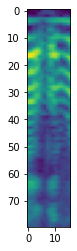

In [10]:
import matplotlib.pyplot as plt
plt.imshow(mel[0].numpy())

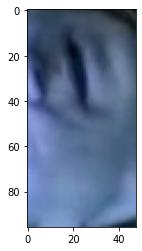

In [11]:
plt.imshow(x[:3,:,:].transpose(0,2).numpy())

#### 3.训练

使用cosine_loss 作为损失函数

In [12]:
#损失函数的定义
logloss = nn.BCELoss() # 交叉熵损失
def cosine_loss(a, v, y):#余弦相似度损失
    """
    a: audio_encoder的输出
    v: video face_encoder的输出
    y: 是否同步的真实值
    """
    d = nn.functional.cosine_similarity(a, v)
    loss = logloss(d.unsqueeze(1), y)

    return loss

In [13]:
def train(device, model, train_data_loader, test_data_loader, optimizer,
          checkpoint_dir=None, checkpoint_interval=None, nepochs=None):

    global global_step, global_epoch
    resumed_step = global_step
    
    while global_epoch < nepochs:
        running_loss = 0.
        prog_bar = tqdm(enumerate(train_data_loader))
        for step, (x, mel, y) in prog_bar:
            model.train()
            optimizer.zero_grad()

            #####TODO###########
            ####################
            #补全模型的训练
            x = x.to(device)

            mel = mel.to(device)

            a, v = model(mel, x)
            y = y.to(device)

            loss = cosine_loss(a, v, y)
            loss.backward()
            optimizer.step()
                
            

            global_step += 1
            cur_session_steps = global_step - resumed_step
            running_loss += loss.item()

            if global_step == 1 or global_step % checkpoint_interval == 0:
                save_checkpoint(
                    model, optimizer, global_step, checkpoint_dir, global_epoch)

            if global_step % hparams.syncnet_eval_interval == 0:
                with torch.no_grad():
                    eval_model(test_data_loader, global_step, device, model, checkpoint_dir)

            prog_bar.set_description('Epoch: {} Loss: {}'.format(global_epoch, running_loss / (step + 1)))

        global_epoch += 1

def eval_model(test_data_loader, global_step, device, model, checkpoint_dir):
    #在测试集上进行评估
    eval_steps = 1400
    print('Evaluating for {} steps'.format(eval_steps))
    losses = []
    while 1:
        for step, (x, mel, y) in enumerate(test_data_loader):

            model.eval()

            # Transform data to CUDA device
            x = x.to(device)

            mel = mel.to(device)

            a, v = model(mel, x)
            y = y.to(device)

            loss = cosine_loss(a, v, y)
            losses.append(loss.item())

            if step > eval_steps: break

        averaged_loss = sum(losses) / len(losses)
        print(averaged_loss)

        return

latest_checkpoint_path = ''
def save_checkpoint(model, optimizer, step, checkpoint_dir, epoch):
    #保存训练的结果 checkpoint
    global latest_checkpoint_path
    
    checkpoint_path = join(
        checkpoint_dir, "checkpoint_step{:09d}.pth".format(global_step))
    optimizer_state = optimizer.state_dict() if hparams.save_optimizer_state else None
    torch.save({
        "state_dict": model.state_dict(),
        "optimizer": optimizer_state,
        "global_step": step,
        "global_epoch": epoch,
    }, checkpoint_path)
    latest_checkpoint_path = checkpoint_path
    print("Saved checkpoint:", checkpoint_path)

def _load(checkpoint_path):
    if use_cuda:
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint

def load_checkpoint(path, model, optimizer, reset_optimizer=False):
    #读取指定checkpoint的保存信息
    global global_step
    global global_epoch

    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    model.load_state_dict(checkpoint["state_dict"])
    if not reset_optimizer:
        optimizer_state = checkpoint["optimizer"]
        if optimizer_state is not None:
            print("Load optimizer state from {}".format(path))
            optimizer.load_state_dict(checkpoint["optimizer"])
    global_step = checkpoint["global_step"]
    global_epoch = checkpoint["global_epoch"]

    return model

**下面开始训练，最终的Loss参考值为0.20左右，此时模型能达到较好的判别效果**

In [14]:
checkpoint_dir = "/kaggle/working/expert_checkpoints/" #指定存储 checkpoint的位置
checkpoint_path = '/kaggle/input/wav2lip24epoch/expert_checkpoints/checkpoint_step000060000.pth'
# 指定加载checkpoint的路径，第一次训练时不需要，后续如果想从某个checkpoint恢复训练，可指定。

if not os.path.exists(checkpoint_dir): os.mkdir(checkpoint_dir)

# Dataset and Dataloader setup
train_dataset = Dataset('train')
test_dataset = Dataset('val')

############TODO#########
#####Train Dataloader and Test Dataloader 
#### 具体的bacthsize等参数，参考 hparams.py文件
train_data_loader = data_utils.DataLoader(
    train_dataset, batch_size=hparams.batch_size, shuffle=True,
    num_workers=hparams.num_workers)

test_data_loader = data_utils.DataLoader(
    test_dataset, batch_size=hparams.batch_size,
    num_workers=8)

device = torch.device("cuda" if use_cuda else "cpu")

# Model
#####定义 SynNet模型，并加载到指定的device上
model = SyncNet().to(device)
print('total trainable params {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

####定义优化器，使用adam，lr参考hparams.py文件
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],
                       lr=1e-5)

if checkpoint_path is not None:
    load_checkpoint(checkpoint_path, model, optimizer, reset_optimizer=True)

train(device, model, train_data_loader, test_data_loader, optimizer,
      checkpoint_dir=checkpoint_dir,
      checkpoint_interval=hparams.syncnet_checkpoint_interval,
      nepochs=27)

total trainable params 16435072
Load checkpoint from: /kaggle/input/wav2lip24epoch/expert_checkpoints/checkpoint_step000060000.pth


Epoch: 20 Loss: 0.4835729799709603: : 2865it [26:26,  1.81it/s]
Epoch: 21 Loss: 0.4813423672791759: : 2865it [24:30,  1.95it/s]
Epoch: 22 Loss: 0.4767525762319565: : 2865it [25:10,  1.90it/s]
Epoch: 23 Loss: 0.47215773716059506: : 1404it [12:02,  1.70it/s]

Saved checkpoint: /kaggle/working/expert_checkpoints/checkpoint_step000070000.pth
Evaluating for 1400 steps


Epoch: 23 Loss: 0.472245811430438: : 1406it [12:32,  6.51s/it]

0.447623890988967


Epoch: 23 Loss: 0.4746017324830849: : 2865it [24:56,  1.91it/s]
Epoch: 24 Loss: 0.4683841840134865: : 2865it [24:07,  1.98it/s]
Epoch: 25 Loss: 0.4698803570882188: : 2865it [23:36,  2.02it/s]
Epoch: 26 Loss: 0.4691496957299038: : 2809it [22:58,  2.12it/s]

Saved checkpoint: /kaggle/working/expert_checkpoints/checkpoint_step000080000.pth
Evaluating for 1400 steps


Epoch: 26 Loss: 0.46914908886803974: : 2811it [23:25,  5.98s/it]

0.41562949712662134


Epoch: 26 Loss: 0.46859301660489455: : 2865it [23:38,  2.02it/s]


### 3.2 训练Wav2Lip
预训练模型 [weight](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/radrabha_m_research_iiit_ac_in/EdjI7bZlgApMqsVoEUUXpLsBxqXbn5z8VTmoxp55YNDcIA?e=n9ljGW)
#### 1. 模型的定义
wav2lip模型的生成器首先对输入进行下采样，然后再经过上采样恢复成原来的大小。为了方便，我们对其中重复利用到的模块进行了封装。

In [15]:
class nonorm_Conv2d(nn.Module): #不需要进行 norm的卷积
    def __init__(self, cin, cout, kernel_size, stride, padding, residual=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            )
        self.act = nn.LeakyReLU(0.01, inplace=True)

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

class Conv2dTranspose(nn.Module):# 逆卷积，上采样
    def __init__(self, cin, cout, kernel_size, stride, padding, output_padding=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        ############TODO###########
        ## 完成self.conv_block: 一个逆卷积和batchnorm组成的 Sequential结构
        self.conv_block = nn.Sequential(
                            nn.ConvTranspose2d(cin, cout, kernel_size, stride, padding, output_padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

**生成器**  
由两个encoder: face_encoder和 audio_encoder, 一个decoder：face_decoder组成。face encoder 和 audio encoder 分别对输入的人脸和语音特征进行降维，得到（1，1，512）的特征，并将二者进行拼接送入到 face decoder中去进行上采样，最终得到和输入一样大小的人脸图像。

In [16]:

#####################TODO############################
#根据下面打印的网络模型图，补全网络的参数

class Wav2Lip(nn.Module):
    def __init__(self):
        super(Wav2Lip, self).__init__()

        self.face_encoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(6, 16, kernel_size=7, stride=1, padding=3)), # 96,96

            nn.Sequential(Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 48,48
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(32, 64, kernel_size=3, stride=2, padding=1),    # 24,24
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(64, 128, kernel_size=3, stride=2, padding=1),   # 12,12
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(128, 256, kernel_size=3, stride=2, padding=1),       # 6,6
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(256, 512, kernel_size=3, stride=2, padding=1),     # 3,3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),
            
            nn.Sequential(Conv2d(512, 512, kernel_size=3, stride=1, padding=0),     # 1, 1
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0)),])

        self.audio_encoder = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

        self.face_decoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(512, 512, kernel_size=1, stride=1, padding=0),),

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=1, padding=0), # 3,3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),), # 6, 6

            nn.Sequential(Conv2dTranspose(768, 384, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),), # 12, 12

            nn.Sequential(Conv2dTranspose(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),), # 24, 24

            nn.Sequential(Conv2dTranspose(320, 128, kernel_size=3, stride=2, padding=1, output_padding=1), 
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),), # 48, 48

            nn.Sequential(Conv2dTranspose(160, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),),]) # 96,96

        self.output_block = nn.Sequential(Conv2d(80, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()) 

    def forward(self, audio_sequences, face_sequences):
        # audio_sequences = (B, T, 1, 80, 16)
        B = audio_sequences.size(0)

        input_dim_size = len(face_sequences.size())
        if input_dim_size > 4:
            audio_sequences = torch.cat([audio_sequences[:, i] for i in range(audio_sequences.size(1))], dim=0)
            face_sequences = torch.cat([face_sequences[:, :, i] for i in range(face_sequences.size(2))], dim=0)

        audio_embedding = self.audio_encoder(audio_sequences) # B, 512, 1, 1

        feats = []
        x = face_sequences
        for f in self.face_encoder_blocks:
            x = f(x)
            feats.append(x)

        x = audio_embedding
        for f in self.face_decoder_blocks:
            x = f(x)
            try:
                x = torch.cat((x, feats[-1]), dim=1)
            except Exception as e:
                print(x.size())
                print(feats[-1].size())
                raise e
            
            feats.pop()

        x = self.output_block(x)

        if input_dim_size > 4:
            x = torch.split(x, B, dim=0) # [(B, C, H, W)]
            outputs = torch.stack(x, dim=2) # (B, C, T, H, W)

        else:
            outputs = x
            
        return outputs

**判别器**  
判别器也是由一系列的卷积神经网络组成，输入一张人脸图片，利用face encoder对其进行降维到512维。

In [17]:

###########TODO##################
####补全判别器模型
class Wav2Lip_disc_qual(nn.Module):
    def __init__(self):
        super(Wav2Lip_disc_qual, self).__init__()

        self.face_encoder_blocks = nn.ModuleList([
            nn.Sequential(nonorm_Conv2d(3, 32, kernel_size=7, stride=1, padding=3)), # 48,96

            nn.Sequential(nonorm_Conv2d(32, 64, kernel_size=5, stride=(1, 2), padding=2), # 48,48
            nonorm_Conv2d(64, 64, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(64, 128, kernel_size=5, stride=2, padding=2),    # 24,24
            nonorm_Conv2d(128, 128, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(128, 256, kernel_size=5, stride=2, padding=2),   # 12,12
            nonorm_Conv2d(256, 256, kernel_size=5, stride=1, padding=2)),

            nn.Sequential(nonorm_Conv2d(256, 512, kernel_size=3, stride=2, padding=1),       # 6,6
            nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=1)),

            nn.Sequential(nonorm_Conv2d(512, 512, kernel_size=3, stride=2, padding=1),     # 3,3
            nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=1),),
            
            nn.Sequential(nonorm_Conv2d(512, 512, kernel_size=3, stride=1, padding=0),     # 1, 1
            nonorm_Conv2d(512, 512, kernel_size=1, stride=1, padding=0)),])

        self.binary_pred = nn.Sequential(nn.Conv2d(512, 1, kernel_size=1, stride=1, padding=0), nn.Sigmoid())
        self.label_noise = .0

    def get_lower_half(self, face_sequences):
        return face_sequences[:, :, face_sequences.size(2)//2:]

    def to_2d(self, face_sequences):
        B = face_sequences.size(0)
        face_sequences = torch.cat([face_sequences[:, :, i] for i in range(face_sequences.size(2))], dim=0)
        return face_sequences

    def perceptual_forward(self, false_face_sequences):
        false_face_sequences = self.to_2d(false_face_sequences)
        false_face_sequences = self.get_lower_half(false_face_sequences)

        false_feats = false_face_sequences
        for f in self.face_encoder_blocks:
            false_feats = f(false_feats)

        false_pred_loss = F.binary_cross_entropy(self.binary_pred(false_feats).view(len(false_feats), -1), 
                                        torch.ones((len(false_feats), 1)).cuda())

        return false_pred_loss

    def forward(self, face_sequences):
        face_sequences = self.to_2d(face_sequences)
        face_sequences = self.get_lower_half(face_sequences)

        x = face_sequences
        for f in self.face_encoder_blocks:
            x = f(x)

        return self.binary_pred(x).view(len(x), -1)

#### 2. 数据集的定义  
在训练时，会用到4个数据：
1. x:输入的图片
2. indiv_mels: 每一张图片所对应语音的mel-spectrogram特征
3. mel: 所有帧对应的200ms的语音mel-spectrogram，用于SyncNet进行唇音同步损失的计算
4. y:真实的与语音对应的，唇音同步的图片。


In [18]:
global_step = 0
global_epoch = 0
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))

syncnet_T = 5
syncnet_mel_step_size = 16

class Dataset(object):
    def __init__(self, split):
        self.all_videos = get_image_list(data_root, split)

    def get_frame_id(self, frame):
        return int(basename(frame).split('.')[0])

    def get_window(self, start_frame):
        start_id = self.get_frame_id(start_frame)
        vidname = dirname(start_frame)

        window_fnames = []
        for frame_id in range(start_id, start_id + syncnet_T):
            frame = join(vidname, '{}.jpg'.format(frame_id))
            if not isfile(frame):
                return None
            window_fnames.append(frame)
        return window_fnames

    def read_window(self, window_fnames):
        if window_fnames is None: return None
        window = []
        for fname in window_fnames:
            img = cv2.imread(fname)
            if img is None:
                return None
            try:
                img = cv2.resize(img, (hparams.img_size, hparams.img_size))
            except Exception as e:
                return None

            window.append(img)

        return window

    def crop_audio_window(self, spec, start_frame):
        if type(start_frame) == int:
            start_frame_num = start_frame
        else:
            start_frame_num = self.get_frame_id(start_frame) # 0-indexing ---> 1-indexing
        start_idx = int(80. * (start_frame_num / float(hparams.fps)))
        
        end_idx = start_idx + syncnet_mel_step_size

        return spec[start_idx : end_idx, :]

    def get_segmented_mels(self, spec, start_frame):
        mels = []
        assert syncnet_T == 5
        start_frame_num = self.get_frame_id(start_frame) + 1 # 0-indexing ---> 1-indexing
        if start_frame_num - 2 < 0: return None
        for i in range(start_frame_num, start_frame_num + syncnet_T):
            m = self.crop_audio_window(spec, i - 2)
            if m.shape[0] != syncnet_mel_step_size:
                return None
            mels.append(m.T)

        mels = np.asarray(mels)

        return mels

    def prepare_window(self, window):
        # 3 x T x H x W
        x = np.asarray(window) / 255.
        x = np.transpose(x, (3, 0, 1, 2))

        return x

    def __len__(self):
        return len(self.all_videos)

    def __getitem__(self, idx):
        while 1:
            idx = random.randint(0, len(self.all_videos) - 1) #随机选择一个视频id
            vidname = self.all_videos[idx]
            img_names = list(glob(join(vidname, '*.jpg')))
            if len(img_names) <= 3 * syncnet_T:
                continue
            
            img_name = random.choice(img_names)
            wrong_img_name = random.choice(img_names)#随机选择帧
            while wrong_img_name == img_name:
                wrong_img_name = random.choice(img_names)

            window_fnames = self.get_window(img_name)
            wrong_window_fnames = self.get_window(wrong_img_name)
            if window_fnames is None or wrong_window_fnames is None:
                continue

            window = self.read_window(window_fnames)
            if window is None:
                continue

            wrong_window = self.read_window(wrong_window_fnames)
            if wrong_window is None:
                continue

            try:
                #读取音频
                wavpath = join(vidname, "audio.wav")
                wav = audio.load_wav(wavpath, hparams.sample_rate)
                #提取完整mel-spectrogram
                orig_mel = audio.melspectrogram(wav).T
            except Exception as e:
                continue
            # 分割 mel-spectrogram
            mel = self.crop_audio_window(orig_mel.copy(), img_name)
            
            if (mel.shape[0] != syncnet_mel_step_size):
                continue

            indiv_mels = self.get_segmented_mels(orig_mel.copy(), img_name)
            if indiv_mels is None: continue

            window = self.prepare_window(window)
            y = window.copy()
            window[:, :, window.shape[2]//2:] = 0.

            wrong_window = self.prepare_window(wrong_window)
            x = np.concatenate([window, wrong_window], axis=0)

            x = torch.FloatTensor(x)
            mel = torch.FloatTensor(mel.T).unsqueeze(0)
            indiv_mels = torch.FloatTensor(indiv_mels).unsqueeze(1)
            y = torch.FloatTensor(y)
            return x, indiv_mels, mel, y

use_cuda: True


In [19]:
ds=Dataset("train")
x, indiv_mels, mel, y=ds[0]
print(x.shape)
print(indiv_mels.shape)
print(mel.shape)
print(y.shape)

torch.Size([6, 5, 96, 96])
torch.Size([5, 1, 80, 16])
torch.Size([1, 80, 16])
torch.Size([3, 5, 96, 96])


#### 3. 训练

In [20]:
#bce 交叉墒loss
logloss = nn.BCELoss()
def cosine_loss(a, v, y):
    d = nn.functional.cosine_similarity(a, v)
    loss = logloss(d.unsqueeze(1), y)

    return loss

device = torch.device("cuda" if use_cuda else "cpu")
syncnet = SyncNet().to(device) # 定义syncnet 模型
for p in syncnet.parameters():
    p.requires_grad = False

    
#####L1 loss    
recon_loss = nn.L1Loss()
def get_sync_loss(mel, g):
    g = g[:, :, :, g.size(3)//2:]
    g = torch.cat([g[:, :, i] for i in range(syncnet_T)], dim=1)
    # B, 3 * T, H//2, W
    a, v = syncnet(mel, g)
    y = torch.ones(g.size(0), 1).float().to(device)
    return cosine_loss(a, v, y)

def train(device, model, disc, train_data_loader, test_data_loader, optimizer, disc_optimizer,
          checkpoint_dir=None, checkpoint_interval=None, nepochs=None):
    global global_step, global_epoch
    resumed_step = global_step

    while global_epoch < nepochs:
        print('Starting Epoch: {}'.format(global_epoch))
        running_sync_loss, running_l1_loss, disc_loss, running_perceptual_loss = 0., 0., 0., 0.
        running_disc_real_loss, running_disc_fake_loss = 0., 0.
        prog_bar = tqdm(enumerate(train_data_loader))
        for step, (x, indiv_mels, mel, gt) in prog_bar:
            disc.train()
            model.train()

            x = x.to(device)
            mel = mel.to(device)
            indiv_mels = indiv_mels.to(device)
            gt = gt.to(device)

            ### Train generator now. Remove ALL grads. 
            #训练生成器
            optimizer.zero_grad()
            disc_optimizer.zero_grad()

            g = model(indiv_mels, x)#得到生成的结果

            if hparams.syncnet_wt > 0.:
                sync_loss = get_sync_loss(mel, g)# 从预训练的expert 模型中获得唇音同步的损失
            else:
                sync_loss = 0.

            if hparams.disc_wt > 0.:
                perceptual_loss = disc.perceptual_forward(g)#判别器的感知损失
            else:
                perceptual_loss = 0.

            l1loss = recon_loss(g, gt)#l1 loss，重建损失
            
            #最终的损失函数
            loss = hparams.syncnet_wt * sync_loss + hparams.disc_wt * perceptual_loss + \
                                    (1. - hparams.syncnet_wt - hparams.disc_wt) * l1loss

            loss.backward()
            optimizer.step()

            ### Remove all gradients before Training disc
            # 训练判别器
            disc_optimizer.zero_grad()

            pred = disc(gt)
            disc_real_loss = F.binary_cross_entropy(pred, torch.ones((len(pred), 1)).to(device))
            disc_real_loss.backward()

            pred = disc(g.detach())
            disc_fake_loss = F.binary_cross_entropy(pred, torch.zeros((len(pred), 1)).to(device))
            disc_fake_loss.backward()

            disc_optimizer.step()

            running_disc_real_loss += disc_real_loss.item()
            running_disc_fake_loss += disc_fake_loss.item()

            # Logs
            global_step += 1
            cur_session_steps = global_step - resumed_step

            running_l1_loss += l1loss.item()
            if hparams.syncnet_wt > 0.:
                running_sync_loss += sync_loss.item()
            else:
                running_sync_loss += 0.

            if hparams.disc_wt > 0.:
                running_perceptual_loss += perceptual_loss.item()
            else:
                running_perceptual_loss += 0.

            if global_step == 1 or global_step % checkpoint_interval == 0:
                save_checkpoint(
                    model, optimizer, global_step, checkpoint_dir, global_epoch)
                save_checkpoint(disc, disc_optimizer, global_step, checkpoint_dir, global_epoch, prefix='disc_')


            if global_step % hparams.eval_interval == 0:
                with torch.no_grad():
                    average_sync_loss = eval_model(test_data_loader, global_step, device, model, disc)

                    if average_sync_loss < .75:
                        hparams.set_hparam('syncnet_wt', 0.03)

            prog_bar.set_description('L1: {}, Sync: {}, Percep: {} | Fake: {}, Real: {}'.format(running_l1_loss / (step + 1),
                                                                                        running_sync_loss / (step + 1),
                                                                                        running_perceptual_loss / (step + 1),
                                                                                        running_disc_fake_loss / (step + 1),
                                                                                        running_disc_real_loss / (step + 1)))

        global_epoch += 1

def eval_model(test_data_loader, global_step, device, model, disc):
    eval_steps = 300
    print('Evaluating for {} steps'.format(eval_steps))
    running_sync_loss, running_l1_loss, running_disc_real_loss, running_disc_fake_loss, running_perceptual_loss = [], [], [], [], []
    while 1:
        for step, (x, indiv_mels, mel, gt) in enumerate((test_data_loader)):
            model.eval()
            disc.eval()

            x = x.to(device)
            mel = mel.to(device)
            indiv_mels = indiv_mels.to(device)
            gt = gt.to(device)

            pred = disc(gt)
            disc_real_loss = F.binary_cross_entropy(pred, torch.ones((len(pred), 1)).to(device))

            g = model(indiv_mels, x)
            pred = disc(g)
            disc_fake_loss = F.binary_cross_entropy(pred, torch.zeros((len(pred), 1)).to(device))

            running_disc_real_loss.append(disc_real_loss.item())
            running_disc_fake_loss.append(disc_fake_loss.item())

            sync_loss = get_sync_loss(mel, g)
            
            if hparams.disc_wt > 0.:
                perceptual_loss = disc.perceptual_forward(g)
            else:
                perceptual_loss = 0.

            l1loss = recon_loss(g, gt)

            loss = hparams.syncnet_wt * sync_loss + hparams.disc_wt * perceptual_loss + \
                                    (1. - hparams.syncnet_wt - hparams.disc_wt) * l1loss

            running_l1_loss.append(l1loss.item())
            running_sync_loss.append(sync_loss.item())
            
            if hparams.disc_wt > 0.:
                running_perceptual_loss.append(perceptual_loss.item())
            else:
                running_perceptual_loss.append(0.)

            if step > eval_steps: break

        print('L1: {}, Sync: {}, Percep: {} | Fake: {}, Real: {}'.format(sum(running_l1_loss) / len(running_l1_loss),
                                                            sum(running_sync_loss) / len(running_sync_loss),
                                                            sum(running_perceptual_loss) / len(running_perceptual_loss),
                                                            sum(running_disc_fake_loss) / len(running_disc_fake_loss),
                                                             sum(running_disc_real_loss) / len(running_disc_real_loss)))
        return sum(running_sync_loss) / len(running_sync_loss)

latest_wav2lip_checkpoint = ''
def save_checkpoint(model, optimizer, step, checkpoint_dir, epoch, prefix=''):
    global latest_wav2lip_checkpoint
    checkpoint_path = join(
        checkpoint_dir, "{}checkpoint_step{:09d}.pth".format(prefix, global_step))
    if 'disc' not in checkpoint_path:
        latest_wav2lip_checkpoint = checkpoint_path
    optimizer_state = optimizer.state_dict() if hparams.save_optimizer_state else None
    torch.save({
        "state_dict": model.state_dict(),
        "optimizer": optimizer_state,
        "global_step": step,
        "global_epoch": epoch,
    }, checkpoint_path)
    print("Saved checkpoint:", checkpoint_path)

def _load(checkpoint_path):
    if use_cuda:
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint


def load_checkpoint(path, model, optimizer, reset_optimizer=False, overwrite_global_states=True):
    global global_step
    global global_epoch

    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    s = checkpoint["state_dict"]
    new_s = {}
    for k, v in s.items():
        new_s[k.replace('module.', '')] = v
    model.load_state_dict(new_s)
    if not reset_optimizer:
        optimizer_state = checkpoint["optimizer"]
        if optimizer_state is not None:
            print("Load optimizer state from {}".format(path))
            optimizer.load_state_dict(checkpoint["optimizer"])
    if overwrite_global_states:
        global_step = checkpoint["global_step"]
        global_epoch = checkpoint["global_epoch"]

    return model

In [21]:
checkpoint_dir = "/kaggle/working/wav2lip_checkpoints"  #checkpoint 存储的位置

# Dataset and Dataloader setup
train_dataset = Dataset('train')
test_dataset = Dataset('val')

train_data_loader = data_utils.DataLoader(
    train_dataset, batch_size=hparams.batch_size, shuffle=True,
    num_workers=hparams.num_workers)

test_data_loader = data_utils.DataLoader(
    test_dataset, batch_size=hparams.batch_size,
    num_workers=4)
device = torch.device("cuda" if use_cuda else "cpu")

 # Model
model = Wav2Lip().to(device)####### 生成器模型
disc = Wav2Lip_disc_qual().to(device)####### 判别器模型

print('total trainable params {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
print('total DISC trainable params {}'.format(sum(p.numel() for p in disc.parameters() if p.requires_grad)))

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],
                       lr=hparams.initial_learning_rate,
                       betas=(0.5, 0.999))#####adam优化器，betas=[0.5,0.999]
disc_optimizer = optim.Adam([p for p in disc.parameters() if p.requires_grad],
                            lr=hparams.disc_initial_learning_rate,
                            betas=(0.5, 0.999))#####adam优化器，betas=[0.5,0.999]

#继续训练的生成器的checkpoint位置
# checkpoint_path=""
# load_checkpoint(checkpoint_path, model, optimizer, reset_optimizer=False)
#继续训练的判别器的checkpoint位置
# disc_checkpoint_path=""
# load_checkpoint(disc_checkpoint_path, disc, disc_optimizer, 
#                             reset_optimizer=False, overwrite_global_states=False)

# syncnet的checkpoint位置，我们将使用此模型计算生成的帧和语音的唇音同步损失
syncnet_checkpoint_path = latest_checkpoint_path
# syncnet_checkpoint_path="/kaggle/working/expert_checkpoints/checkpoint_step000000001.pth"
load_checkpoint(syncnet_checkpoint_path, syncnet, None, reset_optimizer=True,
                            overwrite_global_states=False)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

# Train!
train(device, model, disc, train_data_loader, test_data_loader, optimizer, disc_optimizer,
          checkpoint_dir=checkpoint_dir,
          checkpoint_interval=hparams.checkpoint_interval,
          nepochs=5)

total trainable params 36298035
total DISC trainable params 14113793
Load checkpoint from: /kaggle/working/expert_checkpoints/checkpoint_step000080000.pth
Starting Epoch: 0


0it [00:00, ?it/s]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000000001.pth


L1: 0.182265505194664, Sync: 0.0, Percep: 0.6852962374687195 | Fake: 0.7010602951049805, Real: 0.6852961778640747: : 1it [00:17, 17.39s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000000001.pth


L1: 0.046039844079375475, Sync: 0.0, Percep: 0.7006118735353776 | Fake: 0.6912129632985613, Real: 0.694671366006188: : 2865it [1:02:50,  1.32s/it]

Starting Epoch: 1



L1: 0.040241426927273845, Sync: 0.0, Percep: 0.6867115430867494 | Fake: 0.703810100679967, Real: 0.6803412684308949: : 134it [03:08,  1.32s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000003000.pth
Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000003000.pth
Evaluating for 300 steps


L1: 0.04018904253564499, Sync: 0.0, Percep: 0.6864057969163966 | Fake: 0.7041104413844921, Real: 0.6801264032169625: : 135it [04:04, 17.45s/it]

L1: 0.03741014929597869, Sync: 1.4850089260760475, Percep: 0.6467777455554289 | Fake: 0.7423368034993901, Real: 0.651926989941036


L1: 0.03900269641562074, Sync: 0.0, Percep: 0.6961903256570585 | Fake: 0.6939434029460994, Real: 0.6915473134879406: : 2865it [1:03:52,  1.34s/it]

Starting Epoch: 2



L1: 0.03545909536289238, Sync: 0.0, Percep: 0.6940031975618526 | Fake: 0.6933492843103232, Real: 0.6925399040865632: : 269it [06:00,  1.29s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000006000.pth
Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000006000.pth
Evaluating for 300 steps


L1: 0.03545024025909327, Sync: 0.0, Percep: 0.6940377164770055 | Fake: 0.6933112680912018, Real: 0.6925840098548819: : 270it [06:52, 16.77s/it]

L1: 0.031579675563775444, Sync: 0.9123614119256244, Percep: 0.7057484519832274 | Fake: 0.6807170221034218, Real: 0.7051262636395061


L1: 0.03530552504717471, Sync: 0.0, Percep: 0.6969361525971643 | Fake: 0.6927072046991002, Real: 0.6919782925754734: : 2865it [1:03:34,  1.33s/it]

Starting Epoch: 3



L1: 0.03414407477594248, Sync: 0.0, Percep: 0.6948496932440466 | Fake: 0.6945914035976524, Real: 0.6901939750307857: : 404it [09:00,  1.47s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000009000.pth
Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000009000.pth
Evaluating for 300 steps


L1: 0.03419261850692608, Sync: 0.0, Percep: 0.6947742740313212 | Fake: 0.694661506605737, Real: 0.6901227241680946: : 405it [09:53, 17.03s/it]

L1: 0.02947066765388145, Sync: 0.9377104578649297, Percep: 0.6579884185510523 | Fake: 0.7296747687984916, Real: 0.6585180066964206


L1: 0.03367848934225387, Sync: 0.0, Percep: 0.6942483557768517 | Fake: 0.6947852298643369, Real: 0.6895289202427157: : 2865it [1:03:11,  1.32s/it]

Starting Epoch: 4



L1: 0.03179426823011798, Sync: 0.0, Percep: 0.7001391245615505 | Fake: 0.6897339982314101, Real: 0.6953619473608615: : 539it [12:07,  1.29s/it]

Saved checkpoint: /kaggle/working/wav2lip_checkpoints/checkpoint_step000012000.pth
Saved checkpoint: /kaggle/working/wav2lip_checkpoints/disc_checkpoint_step000012000.pth
Evaluating for 300 steps


L1: 0.03178744904558967, Sync: 0.0, Percep: 0.7001926060076114 | Fake: 0.6896766474953404, Real: 0.6954020820834018: : 540it [12:58, 16.37s/it]

L1: 0.0268396848867483, Sync: 0.6645076638635468, Percep: 0.7485925362390631 | Fake: 0.6411540850120432, Real: 0.7362593973384184


L1: 0.0327194768181282, Sync: 0.16193598365284387, Percep: 0.6984948469290142 | Fake: 0.6914800586292673, Real: 0.6937821723091665: : 2865it [1:04:43,  1.36s/it]


#### 4. 命令行训练
上面是按步骤训练的过程，在`hq_wav2lip_train.py`文件中已经把上述的过程进行了封装，你可以通过以下的命令直接进行训练

In [22]:
# !python wav2lip_train.py --data_root lrs2_preprocessed/ --checkpoint_dir <folder_to_save_checkpoints> --syncnet_checkpoint_path <path_to_expert_disc_checkpoint>

### 4. 模型的推理
当模型训练完毕后，我们只使用生成器的网络模型部分作为我们的推理模型。模型的输入由一段包含人脸的参照视频和一段语音组成。  
在这里我们可以直接使用官方提供给我们的预训练模型[weight](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/radrabha_m_research_iiit_ac_in/EdjI7bZlgApMqsVoEUUXpLsBxqXbn5z8VTmoxp55YNDcIA?e=n9ljGW)下载该模型并放入到指定文件夹下，供之后的推理使用。  
模型的推理过程主要分为以下几个步骤：
1. 输入数据的预处理，包含人脸抠图，视频分帧，提取mel-spectrogram特征等操作。
2. 利用网络模型生成唇音同步的视频帧。
3. 将生成的视频帧准换成视频，并和输入的语音结合，形成最终的输出视频。  


In [23]:
from os import listdir, path
import numpy as np
import scipy, cv2, os, sys, argparse, audio
import json, subprocess, random, string
from tqdm import tqdm
from glob import glob
import torch, face_detection
from models import Wav2Lip
import platform
import audio

In [24]:
checkpoint_path="/kaggle/working/wav2lip_checkpoints/checkpoint_step000000001.pth"#生成器的checkpoint位置
checkpoint_path = latest_wav2lip_checkpoint
face="input_video.mp4" #参照视频的文件位置, *.mp4
speech="input_audio.wav"#输入语音的位置，*.wav
resize_factor=1 #对输入的视频进行下采样的倍率
crop=[0,-1,0,-1] #是否对视频帧进行裁剪,处理视频中有多张人脸时有用
fps=25#视频的帧率
static=False #是否只使用固定的一帧作为视频的生成参照

In [25]:
if not os.path.isfile(face):
    raise ValueError('--face argument must be a valid path to video/image file')


else:# 若输入的是视频格式
    video_stream = cv2.VideoCapture(face)# 读取视频
    fps = video_stream.get(cv2.CAP_PROP_FPS)# 读取 fps

    print('Reading video frames...')

    full_frames = []
    #提取所有的帧
    while 1:
        still_reading, frame = video_stream.read()
        if not still_reading:
            video_stream.release()
            break
        if resize_factor > 1: # 进行下采样，降低分辨率
            frame = cv2.resize(frame, (frame.shape[1]//resize_factor, frame.shape[0]//resize_factor))

        

        y1, y2, x1, x2 =crop  # 裁剪
        if x2 == -1: x2 = frame.shape[1]
        if y2 == -1: y2 = frame.shape[0]

        frame = frame[y1:y2, x1:x2]

        full_frames.append(frame)

print ("Number of frames available for inference: "+str(len(full_frames)))

Reading video frames...
Number of frames available for inference: 210


In [26]:
#检查输入的音频是否为 .wav格式的，若不是则进行转换
if not speech.endswith('.wav'):
    print('Extracting raw audio...')
    command = 'ffmpeg -y -i {} -strict -2 {}'.format(speech, 'temp/temp.wav')

    subprocess.call(command, shell=True)
    speech = 'temp/temp.wav'

wav = audio.load_wav(speech, 16000)#保证采样率为16000
mel = audio.melspectrogram(wav)
print(mel.shape)


(80, 353)


In [27]:
wav2lip_batch_size=128 #推理时输入到网络的batchsize
mel_step_size=16

#提取语音的mel谱
mel_chunks = []
mel_idx_multiplier = 80./fps 
i = 0
while 1:
    start_idx = int(i * mel_idx_multiplier)
    if start_idx + mel_step_size > len(mel[0]):
        mel_chunks.append(mel[:, len(mel[0]) - mel_step_size:])
        break
    mel_chunks.append(mel[:, start_idx : start_idx + mel_step_size])
    i += 1

print("Length of mel chunks: {}".format(len(mel_chunks)))

full_frames = full_frames[:len(mel_chunks)]

batch_size = wav2lip_batch_size

Length of mel chunks: 128


In [28]:
img_size = 96 #默认的输入图片大小
pads=[0,20,0,0] # 填充的长度，保证下巴也在抠图的范围之内
nosmooth=False
face_det_batch_size=16

def get_smoothened_boxes(boxes, T):
    for i in range(len(boxes)):
        if i + T > len(boxes):
            window = boxes[len(boxes) - T:]
        else:
            window = boxes[i : i + T]
        boxes[i] = np.mean(window, axis=0)
    return boxes

#人脸检测函数
def face_detect(images):
    detector = face_detection.FaceAlignment(face_detection.LandmarksType._2D, 
                                            flip_input=False, device=device)

    batch_size = face_det_batch_size

    while 1:
        predictions = []
        try:
            for i in tqdm(range(0, len(images), batch_size)):
                predictions.extend(detector.get_detections_for_batch(np.array(images[i:i + batch_size])))
        except RuntimeError:
            if batch_size == 1: 
                raise RuntimeError('Image too big to run face detection on GPU. Please use the --resize_factor argument')
            batch_size //= 2
            print('Recovering from OOM error; New batch size: {}'.format(batch_size))
            continue
        break

    results = []
    pady1, pady2, padx1, padx2 = pads
    for rect, image in zip(predictions, images):
        if rect is None:
            cv2.imwrite('temp/faulty_frame.jpg', image) # check this frame where the face was not detected.
            raise ValueError('Face not detected! Ensure the video contains a face in all the frames.')

        y1 = max(0, rect[1] - pady1)
        y2 = min(image.shape[0], rect[3] + pady2)
        x1 = max(0, rect[0] - padx1)
        x2 = min(image.shape[1], rect[2] + padx2)

        results.append([x1, y1, x2, y2])

    boxes = np.array(results)
    if not nosmooth: boxes = get_smoothened_boxes(boxes, T=5)
    results = [[image[y1: y2, x1:x2], (y1, y2, x1, x2)] for image, (x1, y1, x2, y2) in zip(images, boxes)]

    del detector
    return results 

box=[-1,-1,-1,-1]

def datagen(frames, mels):
    img_batch, mel_batch, frame_batch, coords_batch = [], [], [], []

    if box[0] == -1:# 如果未指定 特定的人脸边界的话
        if not static:# 是否使用视频的第一帧作为参考
            face_det_results = face_detect(frames) # BGR2RGB for CNN face detection
        else:
            face_det_results = face_detect([frames[0]])
    else:
        print('Using the specified bounding box instead of face detection...')
        y1, y2, x1, x2 = box
        face_det_results = [[f[y1: y2, x1:x2], (y1, y2, x1, x2)] for f in frames] # 裁剪出人脸结果

    for i, m in enumerate(mels):
        idx = 0 if static else i%len(frames)
        frame_to_save = frames[idx].copy()
        face, coords = face_det_results[idx].copy()

        face = cv2.resize(face, (img_size, img_size)) # 重采样到指定大小

        img_batch.append(face)
        mel_batch.append(m)
        frame_batch.append(frame_to_save)
        coords_batch.append(coords)

        if len(img_batch) >= wav2lip_batch_size:
            img_batch, mel_batch = np.asarray(img_batch), np.asarray(mel_batch)

            img_masked = img_batch.copy()
            img_masked[:, img_size//2:] = 0

            img_batch = np.concatenate((img_masked, img_batch), axis=3) / 255.
            mel_batch = np.reshape(mel_batch, [len(mel_batch), mel_batch.shape[1], mel_batch.shape[2], 1])

            yield img_batch, mel_batch, frame_batch, coords_batch
            img_batch, mel_batch, frame_batch, coords_batch = [], [], [], []

    if len(img_batch) > 0:
        img_batch, mel_batch = np.asarray(img_batch), np.asarray(mel_batch)

        img_masked = img_batch.copy()
        img_masked[:, img_size//2:] = 0

        img_batch = np.concatenate((img_masked, img_batch), axis=3) / 255.
        mel_batch = np.reshape(mel_batch, [len(mel_batch), mel_batch.shape[1], mel_batch.shape[2], 1])

        yield img_batch, mel_batch, frame_batch, coords_batch

mel_step_size = 16 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} for inference.'.format(device))


#加载模型
def _load(checkpoint_path):
    if device == 'cuda':
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint

def load_model(path):
    model = Wav2Lip()
    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    s = checkpoint["state_dict"]
    new_s = {}
    for k, v in s.items():
        new_s[k.replace('module.', '')] = v
    model.load_state_dict(new_s)

    model = model.to(device)
    return model.eval()

Using cuda for inference.


In [29]:
os.mkdir('/kaggle/working/temp/')

In [30]:
full_frames = full_frames[:len(mel_chunks)]

batch_size = wav2lip_batch_size
gen = datagen(full_frames.copy(), mel_chunks)  # 进行人脸的裁剪与拼接，6通道

for i, (img_batch, mel_batch, frames, coords) in enumerate(tqdm(gen, 
                                        total=int(np.ceil(float(len(mel_chunks))/batch_size)))):
    #加载模型
    if i == 0:
        model = load_model(checkpoint_path)
        print ("Model loaded")

        frame_h, frame_w = full_frames[0].shape[:-1]
        #暂存临时视频
        out = cv2.VideoWriter('/kaggle/working/temp/result_without_audio.mp4',
                                cv2.VideoWriter_fourcc(*'DIVX'), fps, (frame_w, frame_h))

    img_batch = torch.FloatTensor(np.transpose(img_batch, (0, 3, 1, 2))).to(device)
    mel_batch = torch.FloatTensor(np.transpose(mel_batch, (0, 3, 1, 2))).to(device)
    
    
    ##### 将 img_batch, mel_batch送入模型得到pred
    ##############TODO##############
    with torch.no_grad():
        pred = model(mel_batch, img_batch)
    
    pred = pred.cpu().numpy().transpose(0, 2, 3, 1) * 255.

    for p, f, c in zip(pred, frames, coords):
        y1, y2, x1, x2 = c
        p = cv2.resize(p.astype(np.uint8), (x2 - x1, y2 - y1))

        f[y1:y2, x1:x2] = p
        out.write(f)

out.release()


100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Load checkpoint from: /kaggle/working/wav2lip_checkpoints/checkpoint_step000012000.pth
Model loaded


100%|██████████| 1/1 [00:18<00:00, 18.96s/it]


In [31]:
os.mkdir('/kaggle/working/result/')

In [32]:
#将生成的视频与语音合并
outfile="/kaggle/working/result/result.mp4"# 最终输出结果到该文件夹下
command = 'ffmpeg -y -i {} -i {} -strict -2 -q:v 1 {}'.format(speech, '/kaggle/working/temp/result_without_audio.mp4',outfile)
subprocess.call(command, shell=platform.system() != 'Windows')

0